Course:
<br>https://www.udemy.com/course/data-fusion-with-linear-kalman-filter/

### Import libraries 

In [1]:
import numpy as np
import pandas as pd
from scipy.linalg import expm
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec

np.set_printoptions(suppress=True)

### Problem statement

<br>
We have a pendulum swinging on the rope. We will create simulation. As you can see from formula bellow, we should use sinus, which means, that we would be dealing with non linear system. For cases, where angle is bellow 15 degrees, we can approximate this value into linear system as is written in last formula
<img src="https://thecuriousastronomer.files.wordpress.com/2013/10/20131022-110640.jpg"  width = 300 height=300 />
<i>https://thecuriousastronomer.files.wordpress.com/2013/10/20131022-110640.jpg</i>


Firstly we define object of vehicle, where we will store all data

Then we run simulation of measurement and display real value pendulum swing

In [2]:
def run_simulation(starting_angle:int=15,
                    length_of_rope:float = 10,
                    end_time:int = 10,
                    dt:float = 0.01,
                    g:float = 9.81, 
                    ):
    theta0 = np.deg2rad(starting_angle)
    
    # Linear Model
    A = np.array([[0,1],[-g/length_of_rope,0]])
    # Discretization of matrix
    F = expm(A*dt)
    
    # Set Initial State
    x0 = np.array([theta0,0])
    
    # Save Initial State
    x_lin = x0
    lin_state_history = [x_lin]
    
    # Run Simulation
    num_steps = np.ceil(end_time/dt).astype(int)
    for k in range(1,num_steps+1):
        # Linear
        x_lin = np.matmul(F,x_lin)
        # Save state
        lin_state_history.append(x_lin)
        
    # Return simulated values
    return lin_state_history

In [3]:
lin_state_history = run_simulation(    
                   starting_angle=15,
                   length_of_rope=10,
                   end_time = 5, 
                   dt=0.01)

<IPython.core.display.Javascript object>


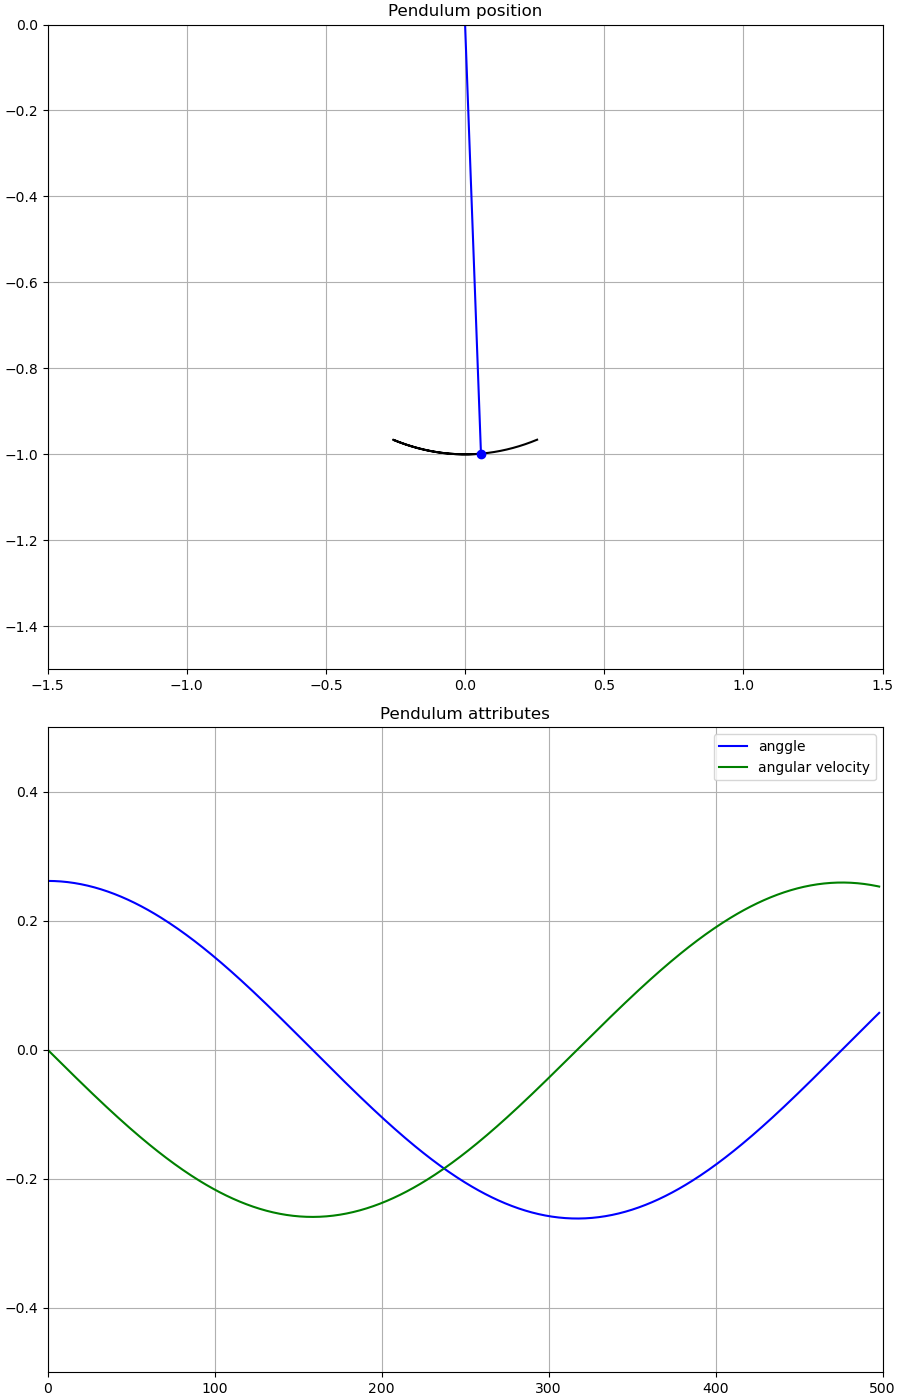

In [4]:
%matplotlib notebook
#fig, ax = plt.subplots(figsize = (14,6))
# Plot Animation
fig_of_plot, axes = plt.subplots(2,1, constrained_layout=True, figsize=(9,14))
axes[0].set_xlim((-1.5, 1.5))
axes[0].set_ylim((-1.5, 0))
axes[0].grid(visible=True)
axes[0].set_title('Pendulum position')
axes[1].grid(visible=True)
axes[1].set_title('Pendulum attributes')
axes[1].set_xlim((0, len(lin_state_history)-1))
axes[1].set_ylim((-0.5, 0.5))


historical_movement, = axes[0].plot([],[],'-k')
rope, = axes[0].plot([], [], 'b-')
end_of_pendulum, = axes[0].plot([], [], 'bo')
angle, = axes[1].plot([], [], 'b-', label = "anggle")
angular_velocity, = axes[1].plot([], [], 'g-', label = "angular velocity")
axes[1].legend()

def update_plot(i):
    if i>1:
        lin_theta_history = np.array(lin_state_history)[:i]
        first_values_history = lin_theta_history[:,0]
        lin_theta = first_values_history[-1]
        second_values_history = lin_theta_history[:,1]
        end_of_pendulum.set_data([np.sin(lin_theta),-np.cos(lin_theta)])
        historical_movement.set_data([np.sin(first_values_history),-np.cos(first_values_history)])
        rope.set_data([0,np.sin(lin_theta)],[0,-np.cos(lin_theta)])
        angle.set_data(np.arange(0, i, 1), first_values_history)
        angular_velocity.set_data(np.arange(0, i, 1), second_values_history)

ani = animation.FuncAnimation(fig_of_plot, update_plot, repeat=False,
                                    frames=len(lin_state_history)-1, interval=1)


plt.show()

<h4>Lets implement prediction step of Kalman filter</h4>
We start with deriving our formula.
<ul>
  <li>Firstly we have angular position and angular rate, which we are trying to calculate</li>
  <li>In this formula, we can basicaly remove part of acceleration as we dont have these measurements. Also we need to linearized this model. In order to do that, we can assume, that up to 15 degrees, error in calculation would be up to 1%, to we can remove sinus</li>
  <li>Then we convert our formula into matrix form</li>
</ul>
<img src="images/Kalman_linearized_non_linear_pendulum.jpg"  width = 800 height=300 />

We define standard class for kalman filter as before. There are no changes

In [5]:
# Definition of Kalman filter
class KalmanFilterBase:
    def __init__(self):
        # variables we would like to track
        self.state = None
        self.covariance = None
        self.innovation = None
        self.innovation_covariance = None

    def get_current_state(self):
        if self.state is not None:
            return self.state.tolist()
        return None

    def get_current_covariance(self):
        if self.covariance is not None:
            return self.covariance.tolist()
        return None

    def get_last_innovation(self):
        if self.innovation is not None:
            return self.innovation.tolist()
        return None

    def get_last_innovation_covariance(self):
        if self.innovation_covariance is not None:
            return self.innovation_covariance.tolist()
        return None

To implement case specific kalman filter, you can mention difference in A matrix, that is used for our time propagation and F matrix, that is discretized form of matrix A. 

To be able to add noise in our P matrix, we are using Q matrix, where we define only second row which stands for angular rate and multiply it by torque std. 

In [6]:
# Kalman Filter Model
class KalmanFilterModel(KalmanFilterBase):

    
    def initialise(self, 
                   time_step, 
                   torque_std, 
                   meas_std, 
                   length = 0.5, 
                   init_on_measurement=False, 
                   init_pos_std = 0.1, 
                   init_vel_std = 0.1):
        self.dt = time_step
        self.init_pos_std = init_pos_std
        self.init_vel_std = init_vel_std
        
        # Set Model F and H Matrices
        A = np.array([[0,1],[-9.81/length,0]])
        self.F = expm(A*time_step) # Note: use the expm() function
        self.H = np.array([[1,0]]) # Note: use np.array([[a,b]]) for a row matrix

        # Set R and Q Matrices
        self.Q = np.diag(np.array([0,1]) * (torque_std*torque_std)) # Note: use variable 'torque_std'
        self.R = meas_std*meas_std # Note: use variable 'meas_std'

        # Set Initial State and Covariance 
        if init_on_measurement is False:
            self.state = np.transpose(np.array([[0.26179939,0]])) # Assume we are at zero position and velocity
            self.covariance = np.diag(np.array([init_pos_std*init_pos_std,init_vel_std*init_vel_std]))
        
        return
    
    def prediction_step(self):
        # Make Sure Filter is Initialised
        if self.state is not None:
            x = self.state
            P = self.covariance

            # Calculate Kalman Filter Prediction
            x_predict = np.matmul(self.F, x) 
            P_predict = np.matmul(self.F, np.matmul(P, np.transpose(self.F))) + self.Q

            # Save Predicted State
            self.state = x_predict
            self.covariance = P_predict

        return

Lets run our kalman filter. We can see, that as we set initial state very close to real state, pendulum is moving almost precisely as real simulation

In [7]:
kf_options =  {'torque_std':0.01, # Q Matrix
              'meas_std':np.deg2rad(0.1), # R Matrix  
              'init_pos_std':np.deg2rad(10),
              'init_vel_std':np.deg2rad(10),
              'init_on_measurement':False, 
              'time_step': 0.01, 
              'length' : 10}

In [8]:
lin_state_history = run_simulation(    
                   starting_angle=15,
                   length_of_rope=10,
                   end_time = 20, 
                   dt=0.01)

In [9]:
kalman_filter = KalmanFilterModel()
kalman_filter.initialise(**kf_options)

states = []
covariances = []
estimation_errors = []
for step_id in range(len(lin_state_history)):
    # KF Prediction
    kalman_filter.prediction_step()
    states.append(kalman_filter.get_current_state())
    covariances.append(kalman_filter.get_current_covariance())
    estimation_errors.append(np.array(kalman_filter.get_current_state()) 
                             - np.array(lin_state_history[step_id]))
states = np.array(states)
covariances = np.array(covariances)
estimation_errors = np.array(estimation_errors)
lin_state_history = np.array(lin_state_history)

<IPython.core.display.Javascript object>


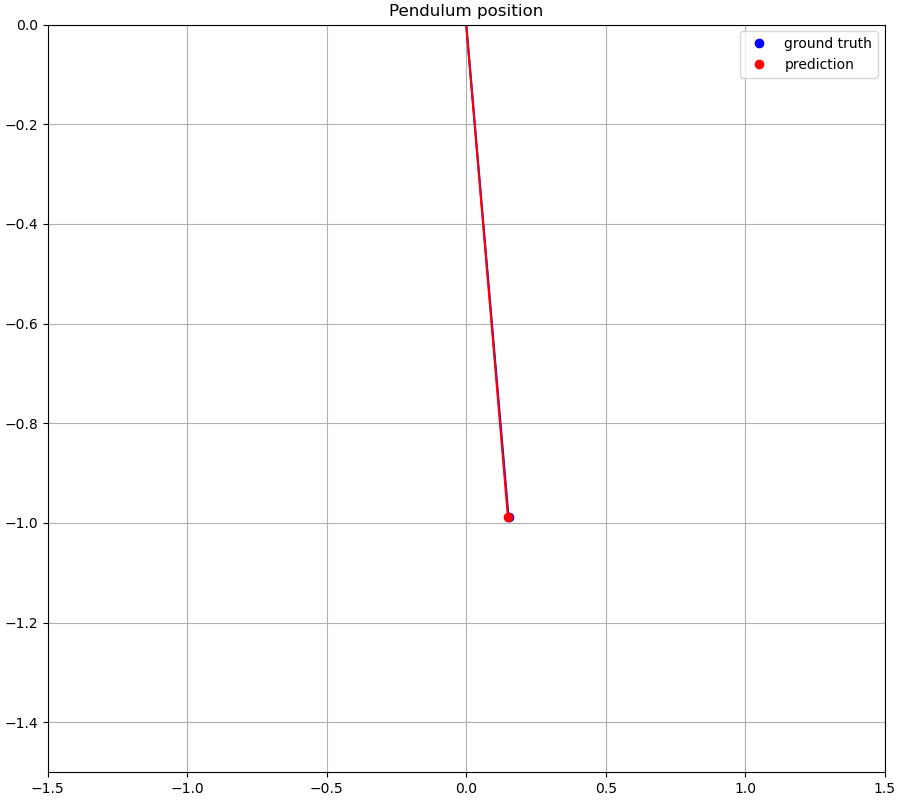

In [10]:
%matplotlib notebook
#fig, ax = plt.subplots(figsize = (8,6))
# Plot Animation
fig_of_plot, axes = plt.subplots(constrained_layout=True, figsize=(9,8))
axes.set_xlim((-1.5, 1.5))
axes.set_ylim((-1.5, 0))
axes.grid(visible=True)
axes.set_title('Pendulum position')


rope_gt, = axes.plot([], [], 'b-')
end_of_pendulum_gt, = axes.plot([], [], 'bo', label = "ground truth")
rope_pred, = axes.plot([], [], 'r-')
end_of_pendulum_pred, = axes.plot([], [], 'ro', label = "prediction")

def update_plot(i):
    if i>1:
        pendulum_gt = lin_state_history[i,:]
        pendulum_pred = states[i,:]
        rope_gt.set_data([0,np.sin(pendulum_gt[0])],[0,-np.cos(pendulum_gt[0])])
        end_of_pendulum_gt.set_data([np.sin(pendulum_gt[0]),-np.cos(pendulum_gt[0])])
        rope_pred.set_data([0,np.sin(pendulum_pred[0])],[0,-np.cos(pendulum_pred[0])])
        end_of_pendulum_pred.set_data([np.sin(pendulum_pred[0]),-np.cos(pendulum_pred[0])])


ani = animation.FuncAnimation(fig_of_plot, update_plot, repeat=False,
                                    frames=len(lin_state_history)-1, interval=0.001)

plt.legend()
plt.show()

Following graph is showing, that we are able with our guess somehow follow reality.

<IPython.core.display.Javascript object>


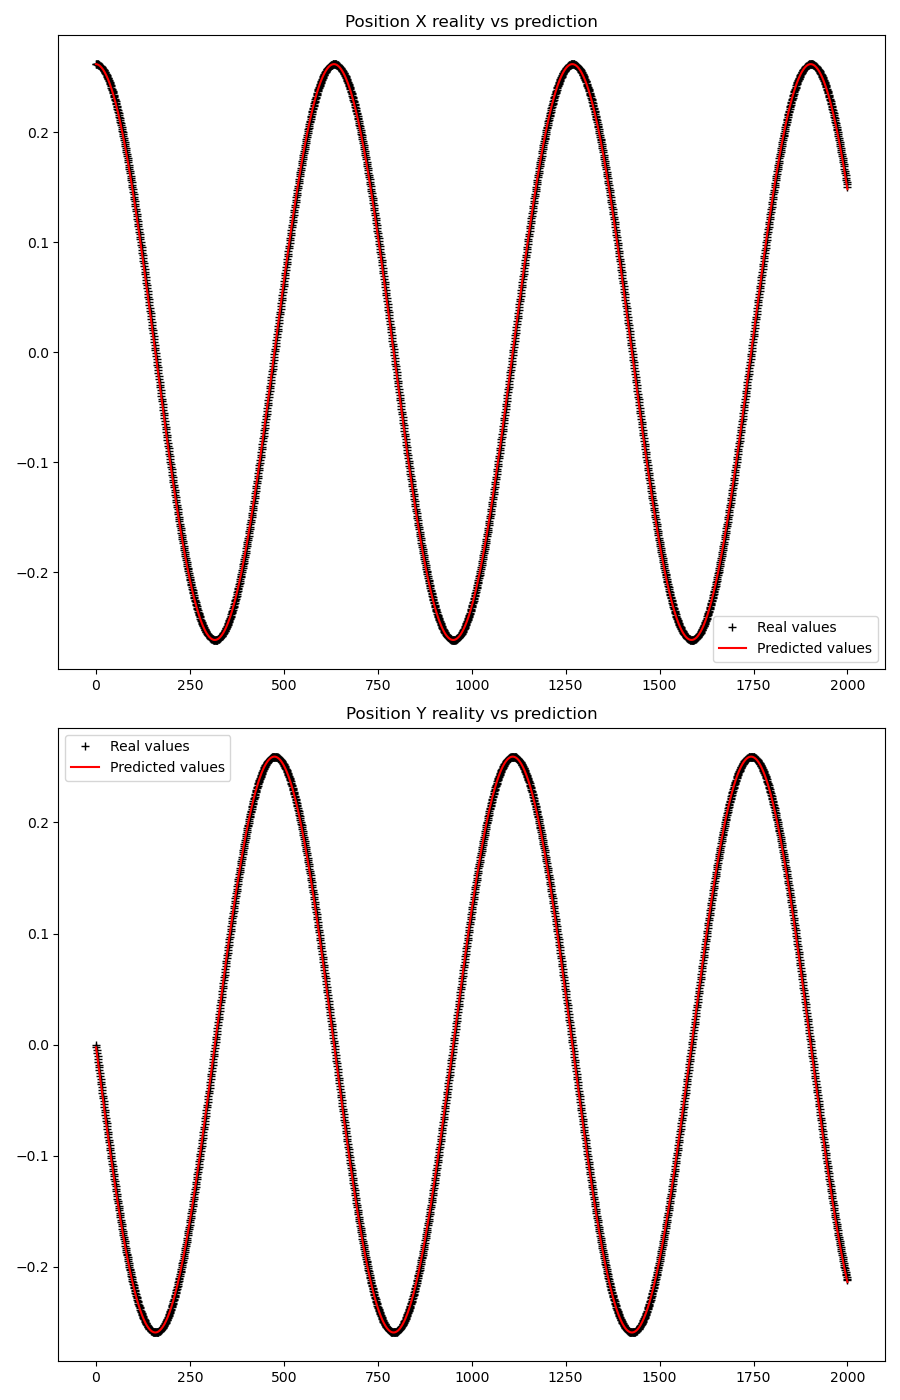

In [11]:
fig, ax = plt.subplots(2,1,figsize = (9,14))

ax[0].plot(lin_state_history[:,0], "+k", label = "Real values")
ax[0].plot(states[:,0], "-r", label = "Predicted values")
ax[0].legend()
ax[0].set_title("Position X reality vs prediction")

ax[1].plot(lin_state_history[:,1], "+k", label = "Real values")
ax[1].plot(states[:,1], "-r", label = "Predicted values")
ax[1].legend()
ax[1].set_title("Position Y reality vs prediction")


plt.tight_layout()
plt.show()

We can also see as our model is not learning, that model covariance is growing.

<IPython.core.display.Javascript object>


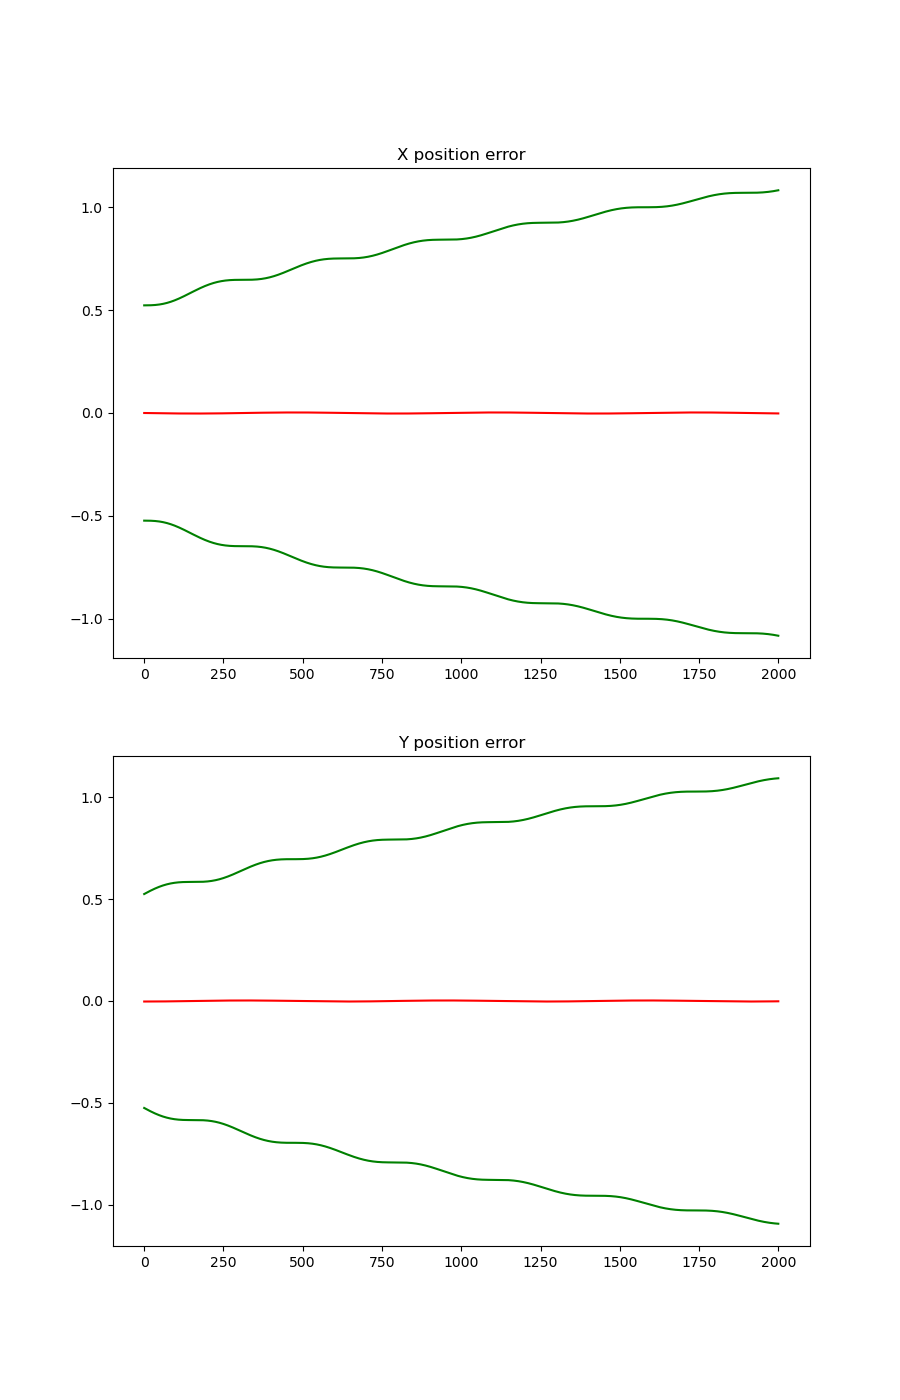

In [12]:
fig, ax = plt.subplots(2,1,figsize = (9,14))

ax[0].plot(states[:,0].reshape(-1,1,)-lin_state_history[:,0].reshape(-1,1,), "-r", label = "Difference in values")
ax[0].plot(3*np.sqrt(covariances[:,0,0]), "-g", label = "Upper 3 sigma")
ax[0].plot(-3*np.sqrt(covariances[:,0,0]), "-g", label = "Lower 3 sigma")
#ax[0].legend()
ax[0].set_title("X position error")

ax[1].plot(states[:,1].reshape(-1,1,)-lin_state_history[:,1].reshape(-1,1,), "-r", label = "Difference in values")
ax[1].plot(3*np.sqrt(covariances[:,1,1]), "-g", label = "Upper 3 sigma")
ax[1].plot(-3*np.sqrt(covariances[:,1,1]), "-g", label = "Lower 3 sigma")
#ax[1].legend()
ax[1].set_title("Y position error")

#plt.tight_layout()
plt.show()

<h4>Lets implement update step of Kalman filter</h4>

In [13]:
# Kalman Filter Model
class KalmanFilterModel(KalmanFilterBase):

    
    def initialise(self, 
                   time_step, 
                   torque_std, 
                   meas_std, 
                   length = 0.5, 
                   init_on_measurement=False, 
                   init_pos_std = 0.1, 
                   init_vel_std = 0.1):
        self.dt = time_step
        self.init_pos_std = init_pos_std
        self.init_vel_std = init_vel_std
        
        # Set Model F and H Matrices
        A = np.array([[0,1],[-9.81/length,0]])
        self.F = expm(A*time_step) # Note: use the expm() function
        self.H = np.array([[1,0]]) # Note: use np.array([[a,b]]) for a row matrix

        # Set R and Q Matrices
        self.Q = np.diag(np.array([0,1]) * (torque_std*torque_std)) # Note: use variable 'torque_std'
        self.R = meas_std*meas_std # Note: use variable 'meas_std'

        # Set Initial State and Covariance 
        if init_on_measurement is False:
            self.state = np.transpose(np.array([[0.5,0.5]])) # Assume we are at zero position and velocity
            self.covariance = np.diag(np.array([init_pos_std*init_pos_std,init_vel_std*init_vel_std]))
        
        return
    
    def prediction_step(self):
        # Make Sure Filter is Initialised
        if self.state is not None:
            x = self.state
            P = self.covariance

            # Calculate Kalman Filter Prediction
            x_predict = np.matmul(self.F, x) 
            P_predict = np.matmul(self.F, np.matmul(P, np.transpose(self.F))) + self.Q

            # Save Predicted State
            self.state = x_predict
            self.covariance = P_predict

        return

    def update_step(self, measurement):

        # Make Sure Filter is Initialised
        if self.state is not None and self.covariance is not None:
            x = self.state
            P = self.covariance
            H = self.H
            R = self.R

            # Calculate Kalman Filter Update
            z = measurement
            z_hat = x[0]
            y = z - z_hat
            S = np.matmul(H,np.matmul(P,np.transpose(H))) + R
            K = np.matmul(P,np.matmul(np.transpose(H),np.linalg.inv(S)))
            x_update = x + K*y # Since y is a scalar, we can't use np.matmul(K, y)
            P_update = np.matmul( (np.eye(2) - np.matmul(K,H)), P)

            # Save Updated State
            self.innovation = y
            self.innovation_covariance = S
            self.state = x_update
            self.covariance = P_update

        else:
            # Set Initial State and Covariance 
            self.state = np.transpose(np.array([[measurement,0]]))
            self.covariance = np.diag(np.array([self.R,self.init_vel_std*self.init_vel_std])) # Assume we don't know our velocity

        return 

Lets run our simulation

In [14]:
kf_options =  {'torque_std':0.01, # Q Matrix
              'meas_std':np.deg2rad(0.1), # R Matrix  
              'init_pos_std':np.deg2rad(10),
              'init_vel_std':np.deg2rad(10),
              'init_on_measurement':False, 
              'time_step': 0.01, 
              'length' : 10}

In [15]:
lin_state_history = run_simulation(    
                   starting_angle=20,
                   length_of_rope=15,
                   end_time = 20, 
                   dt=0.01)

In [16]:
kalman_filter = KalmanFilterModel()
kalman_filter.initialise(**kf_options)

states = []
covariances = []
estimation_errors = []
for step_id in range(len(lin_state_history)):
    # KF Prediction
    kalman_filter.prediction_step()
    kalman_filter.update_step(np.array(lin_state_history[step_id])[0])
    states.append(kalman_filter.get_current_state())
    covariances.append(kalman_filter.get_current_covariance())
    estimation_errors.append(np.array(kalman_filter.get_current_state()) 
                             - np.array(lin_state_history[step_id]))

    
states = np.array(states)
covariances = np.array(covariances)
estimation_errors = np.array(estimation_errors)
lin_state_history = np.array(lin_state_history)

Lets visualize swinging of the pendulum measured and predicted by Kalman Filter

<IPython.core.display.Javascript object>


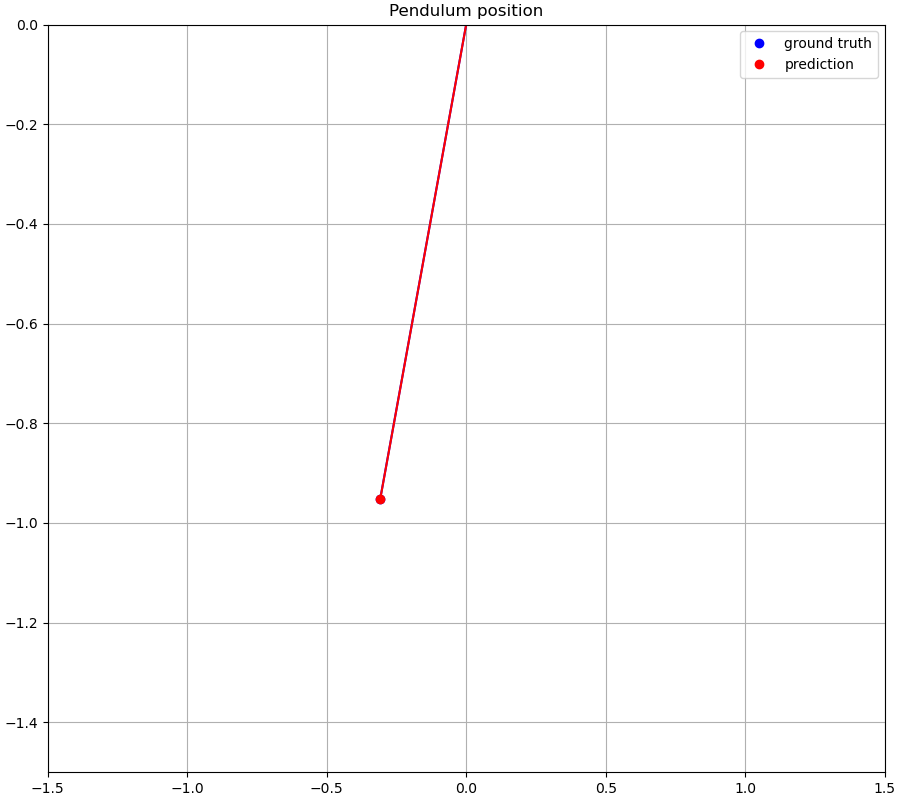

In [17]:
%matplotlib notebook
#fig, ax = plt.subplots(figsize = (8,6))
# Plot Animation
fig_of_plot, axes = plt.subplots(constrained_layout=True, figsize=(9,8))
axes.set_xlim((-1.5, 1.5))
axes.set_ylim((-1.5, 0))
axes.grid(visible=True)
axes.set_title('Pendulum position')


rope_gt, = axes.plot([], [], 'b-')
end_of_pendulum_gt, = axes.plot([], [], 'bo', label = "ground truth")
rope_pred, = axes.plot([], [], 'r-')
end_of_pendulum_pred, = axes.plot([], [], 'ro', label = "prediction")

def update_plot(i):
    if i>1:
        pendulum_gt = lin_state_history[i,:]
        pendulum_pred = states[i,:]
        rope_gt.set_data([0,np.sin(pendulum_gt[0])],[0,-np.cos(pendulum_gt[0])])
        end_of_pendulum_gt.set_data([np.sin(pendulum_gt[0]),-np.cos(pendulum_gt[0])])
        rope_pred.set_data([0,np.sin(pendulum_pred[0])],[0,-np.cos(pendulum_pred[0])])
        end_of_pendulum_pred.set_data([np.sin(pendulum_pred[0]),-np.cos(pendulum_pred[0])])


ani = animation.FuncAnimation(fig_of_plot, update_plot, repeat=False,
                                    frames=len(lin_state_history)-1, interval=0.001)

plt.legend()
plt.show()

When we compare our prediction to the measurement, we see, that it match pretty closely

<IPython.core.display.Javascript object>


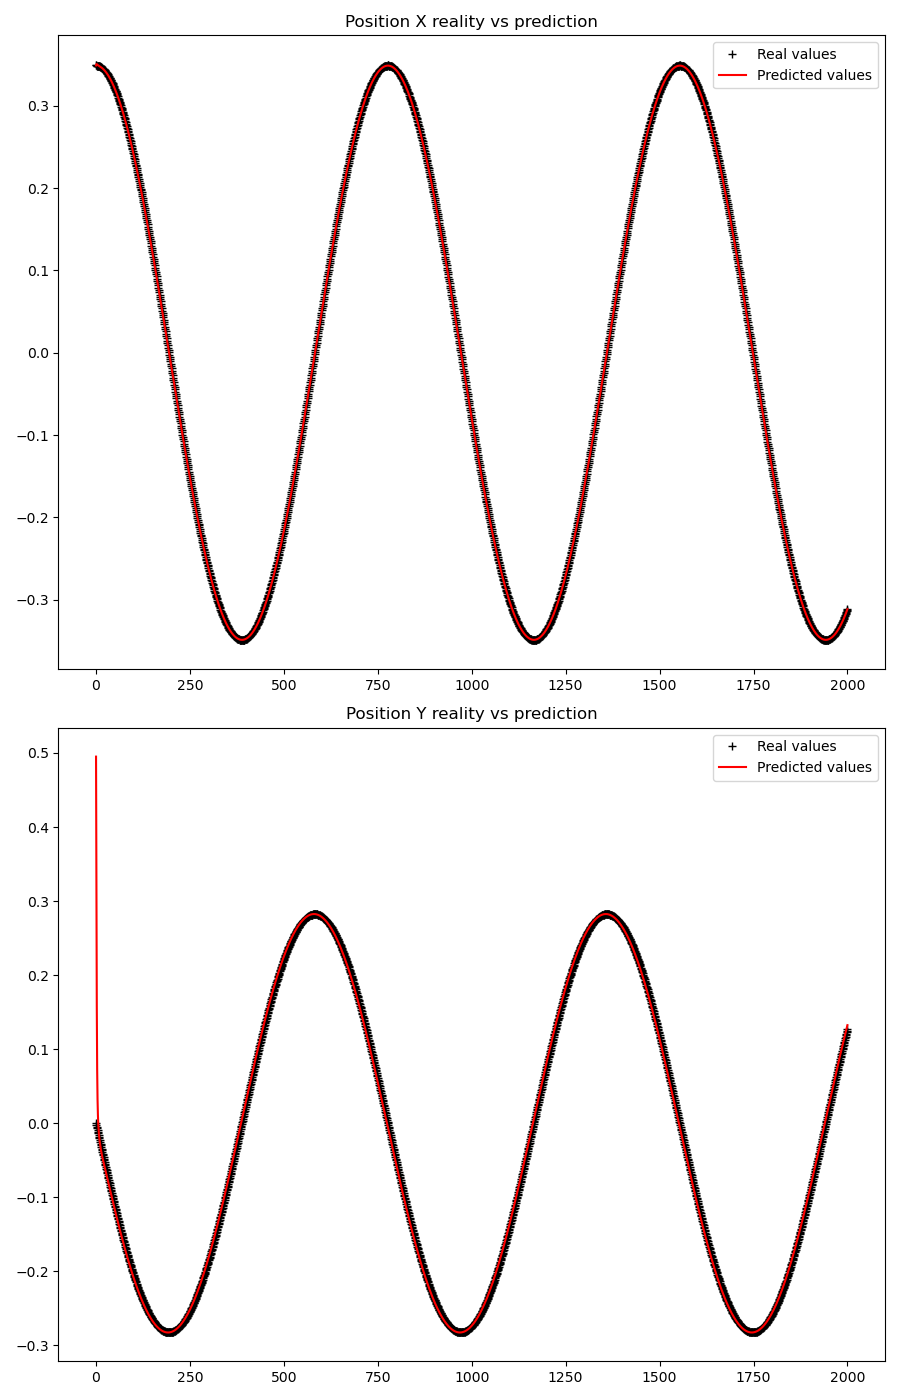

In [18]:
fig, ax = plt.subplots(2,1,figsize = (9,14))

ax[0].plot(lin_state_history[:,0], "+k", label = "Real values")
ax[0].plot(states[:,0], "-r", label = "Predicted values")
ax[0].legend()
ax[0].set_title("Position X reality vs prediction")

ax[1].plot(lin_state_history[:,1], "+k", label = "Real values")
ax[1].plot(states[:,1], "-r", label = "Predicted values")
ax[1].legend()
ax[1].set_title("Position Y reality vs prediction")


plt.tight_layout()
plt.show()

Even our covariance holds very tight

<IPython.core.display.Javascript object>


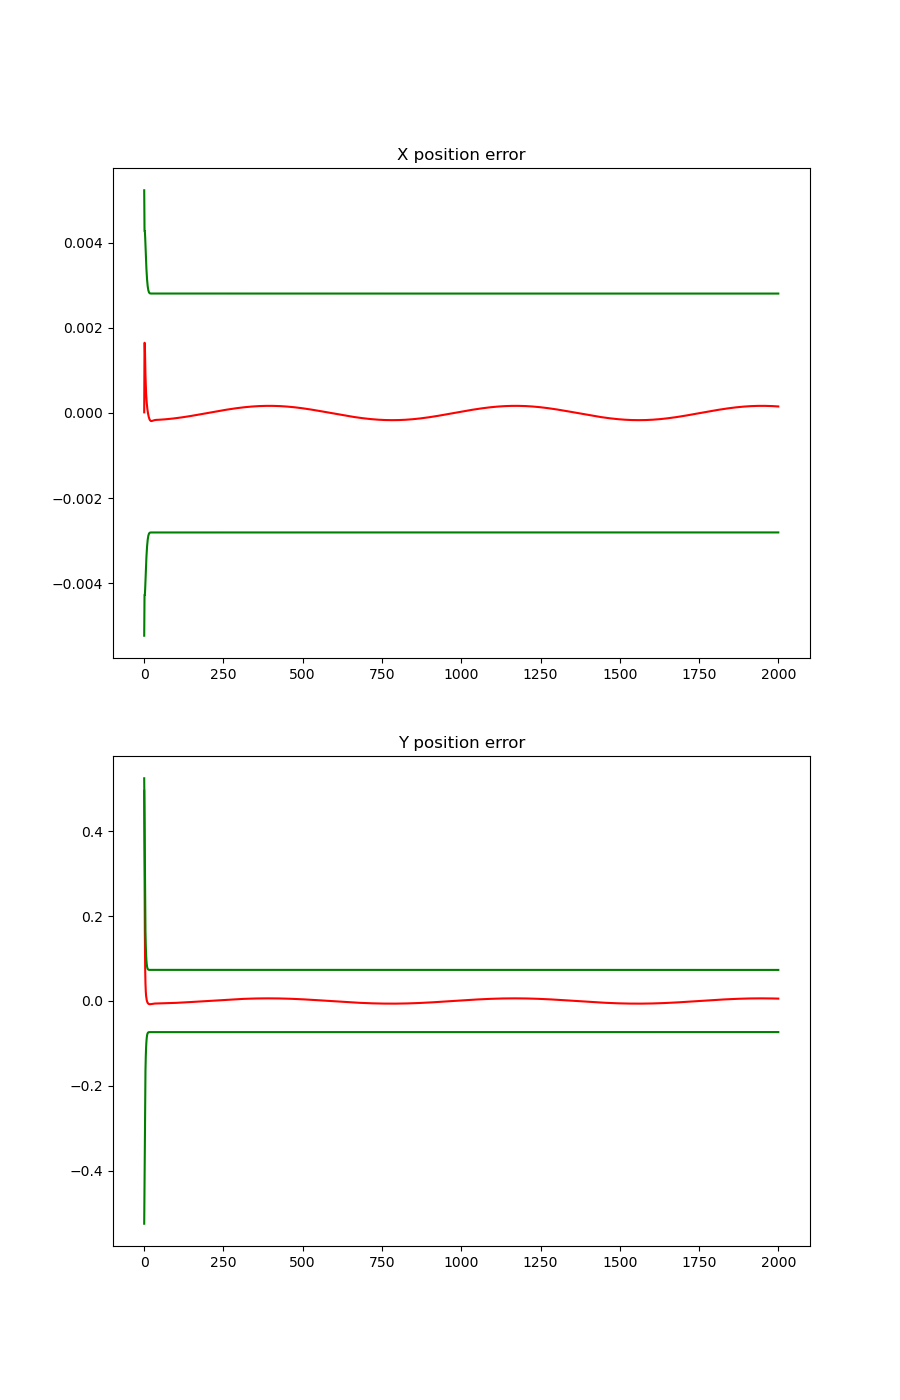

In [19]:
fig, ax = plt.subplots(2,1,figsize = (9,14))

ax[0].plot(states[:,0].reshape(-1,1,)-lin_state_history[:,0].reshape(-1,1,), "-r", label = "Difference in values")
ax[0].plot(3*np.sqrt(covariances[:,0,0]), "-g", label = "Upper 3 sigma")
ax[0].plot(-3*np.sqrt(covariances[:,0,0]), "-g", label = "Lower 3 sigma")
#ax[0].legend()
ax[0].set_title("X position error")

ax[1].plot(states[:,1].reshape(-1,1,)-lin_state_history[:,1].reshape(-1,1,), "-r", label = "Difference in values")
ax[1].plot(3*np.sqrt(covariances[:,1,1]), "-g", label = "Upper 3 sigma")
ax[1].plot(-3*np.sqrt(covariances[:,1,1]), "-g", label = "Lower 3 sigma")
#ax[1].legend()
ax[1].set_title("Y position error")

#plt.tight_layout()
plt.show()